# PyMC3 minimal working example and diagnostics
- Python package for Bayesian statistical modeling and Probabilistic Programming;
- Focus on advanced Markov chain Monte Carlo (MCMC) and variational inference (VI) algorithms;
- Great flexibility and direct interaction with the model.

## Useful links
- Get started with [PyMC3](https://docs.pymc.io/notebooks/getting_started)
- PyMC3 parameters [setting](https://docs.pymc.io/api/inference.html)
- PyMC3 [Github](https://github.com/pymc-devs/pymc3)
- PyMC3 [paper](https://peerj.com/articles/cs-55/)

## import X and y
- X: $23,856$ by $3$, the first gene has non-zero effect.
- y: $23,856$

In [ ]:
import os
import numpy as np, pandas as pd
X = pd.read_csv('/home/min/Downloads/deletion.genes.block30.for_simu.sample.combined.genes.block_51_53.gz', compression = "gzip", sep = "\t", header = None, dtype = float)
y = np.loadtxt("/home/min/Downloads/deletion.genes.block30.for_simu.sample.combined.y.gz", dtype = int)

## Spike and Slab model
Spike-and-Slab Model [link](https://www.kaggle.com/melondonkey/bayesian-spike-and-slab-in-pymc3)

In [2]:
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

`pi_varbvs`, `mu_varbvs` and `si_varbvs` are from whole genome varbvs.

$\beta_k = (1-\pi_k)\delta_0 + \pi_k N(\mu, \sigma)$
- `pi_varbvs`: $\pi_k$ in spike-and-slab prior
- `mu_varbvs`: $\mu$ in spike-and-slab prior for β$_k$
- `si_varbvs`: $\sigma$ in spike-and-slab prior for β$_k$

In [4]:
pi_varbvs = 0.051366009925488
mu_varbvs = 0.783230896500752
si_varbvs = 0.816999481742865

### Parameters
- iteration: The number of repetition;
- tune_prop: The proportion of tuning to iteration; if iteration = 10000 and tune_prop = 0.25, then tuning number is 2500. Tune means we discard the first n tuning samples; Default is 500 tuning samples.
- n_chain: The number of chains.
- n_core: The number of cores used for sampling.
- target_accept: Adapt the step size such that the average acceptance probability across the trajectories are close to target_accept. Default is 0.8. Higher values for target_accept lead to smaller step sizes.

In [9]:
iteration = 10000
tune_prop = 0.25
seed = 1
n_chain = 6
n_core = 6
target_accept = 0.98

### Model
$\beta_{\text{offset}} \sim N(0,1)$ \
$\beta = \mu + \sigma * \beta_{\text{offset}}$ \
$\alpha_{\text{offset}} \sim U(-1,1)$ \
$\alpha = \text{lower} + (\alpha_{\text{offset}}+1)/2*(\text{upper}-\text{lower})$, where upper = log$\frac{\text{case prop}}{1-\text{case prop}}$, lower = log$\frac{\text{prevalence}}{1-\text{prevalence}}$

In [15]:
def get_model(y, X, pi0 = pi_varbvs, mu = mu_varbvs, sigma = si_varbvs, prevalence = 0.05, scale = True):
    case_prop = sum(y) / y.shape[0]
    invlogit = lambda x: 1/(1 + tt.exp(-x))
    upper = np.log(case_prop / (1-case_prop))
    lower = np.log(prevalence / (1-prevalence))
    model = pm.Model()
    with model:
        xi = pm.Bernoulli('xi', pi0, shape = X.shape[1]) # inclusion probability for each variable        
        if scale:
            # reparameterization to non-centered hierarchical model helps with sampling at hierarchical funnel
            beta_offset = pm.Normal('beta_offset', mu = 0, sd = 1, shape = X.shape[1]) # Prior for the non-zero coefficients
            alpha_offset = pm.distributions.continuous.Uniform("alpha_offset", lower = -1, upper = 1)
            beta = pm.Deterministic("beta", mu + beta_offset * sigma)
            alpha = pm.Deterministic("alpha", lower + (alpha_offset+1)/2*(upper - lower))
        else:
            beta = pm.Normal('beta', mu = mu, sd = sigma, shape = X.shape[1])
            alpha = pm.distributions.continuous.Uniform("alpha", lower = lower, upper = upper)
        p = pm.math.dot(X, xi * beta) # Deterministic function to map the stochastics to the output
        y_obs = pm.Bernoulli('y_obs', invlogit(p + alpha), observed = y)  # Data likelihood
    return model

In [11]:
model = get_model(y,X)

In [12]:
model

In [13]:
with model:
    trace1 = pm.sample(draws = iteration, random_seed = seed, cores = min(n_core, n_chain), progressbar = True, chains = n_chain, tune = int(tune_prop*iteration), nuts = {"target_accept": target_accept})

INFO: Multiprocess sampling (6 chains in 6 jobs)

INFO: CompoundStep

INFO: >BinaryGibbsMetropolis: [xi]

INFO: >NUTS: [alpha_offset, beta_offset]

Sampling 6 chains, 0 divergences: 100%|##########| 75000/75000 [32:02<00:00, 39.02draws/s]


In [17]:
pd.DataFrame({'inclusion_probability': np.apply_along_axis(np.mean, 0, trace1['xi']),
              'beta': np.apply_along_axis(np.mean, 0, np.multiply(trace1["beta"], trace1["xi"])),
              'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace1['xi'] * trace1['beta']) / np.apply_along_axis(np.sum, 0, trace1['xi'])
             })

,inclusion_probability,beta,beta_given_inclusion
0,1.000000,1.707312,1.707312
1,0.015300,0.000662,0.043256
2,0.031883,0.015019,0.471068


## MCMC Trace Diagnostics
- PyMC3 MCMC Trace [Diagnostics](https://eigenfoo.xyz/bayesian-modelling-cookbook/#mcmc-trace-diagnostics)
- PyMC3 diagnosing Biased Inference with [Divergences](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html)

$\hat{R}$: the Gelman–Rubin statistic; the potential scale reduction factor (PSRF); can be interpreted as a convergence diagnostic. It measures how similar the chains are. Ideally it should be close to 1.

In [14]:
pm.summary(trace1).round(4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
xi[0],1.000,0.000,1.000,1.000,0.000,0.000,60000.0,60000.0,60000.0,60000.0,NaN
xi[1],0.015,0.123,0.000,0.000,0.001,0.000,43090.0,43090.0,43090.0,43090.0,1.0
xi[2],0.032,0.176,0.000,0.000,0.001,0.001,42036.0,42036.0,42036.0,42036.0,1.0
beta_offset[0],1.131,0.391,0.396,1.858,0.002,0.001,42810.0,37975.0,43438.0,33265.0,1.0
beta_offset[1],-0.006,1.004,-1.943,1.819,0.005,0.005,45691.0,24893.0,45714.0,38542.0,1.0
beta_offset[2],-0.010,1.000,-1.903,1.855,0.005,0.004,45171.0,25065.0,45213.0,36553.0,1.0
alpha_offset,0.992,0.006,0.982,1.000,0.000,0.000,41540.0,41330.0,26786.0,16696.0,1.0
beta[0],1.707,0.319,1.107,2.301,0.002,0.001,42810.0,40368.0,43438.0,33265.0,1.0
beta[1],0.778,0.821,-0.804,2.269,0.004,0.003,45691.0,34427.0,45714.0,38542.0,1.0
beta[2],0.775,0.817,-0.772,2.298,0.004,0.003,45171.0,34812.0,45213.0,36553.0,1.0


### Check the traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47bb44f690>,
      dtype=object)

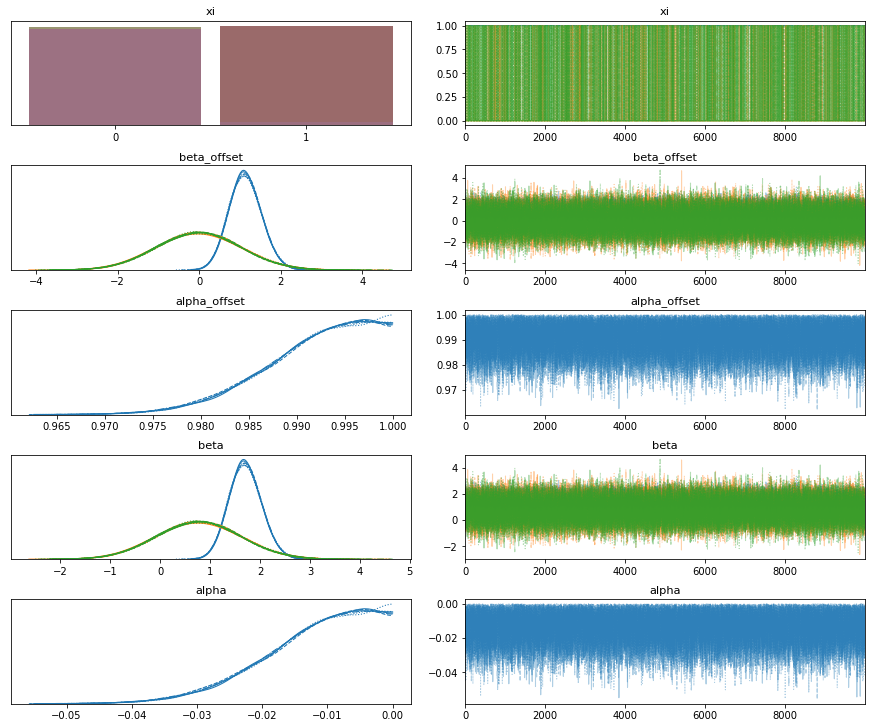

In [16]:
pm.traceplot(trace1)

### Check if posteriors look reasonable

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f47ad0f3d10>,
      dtype=object)

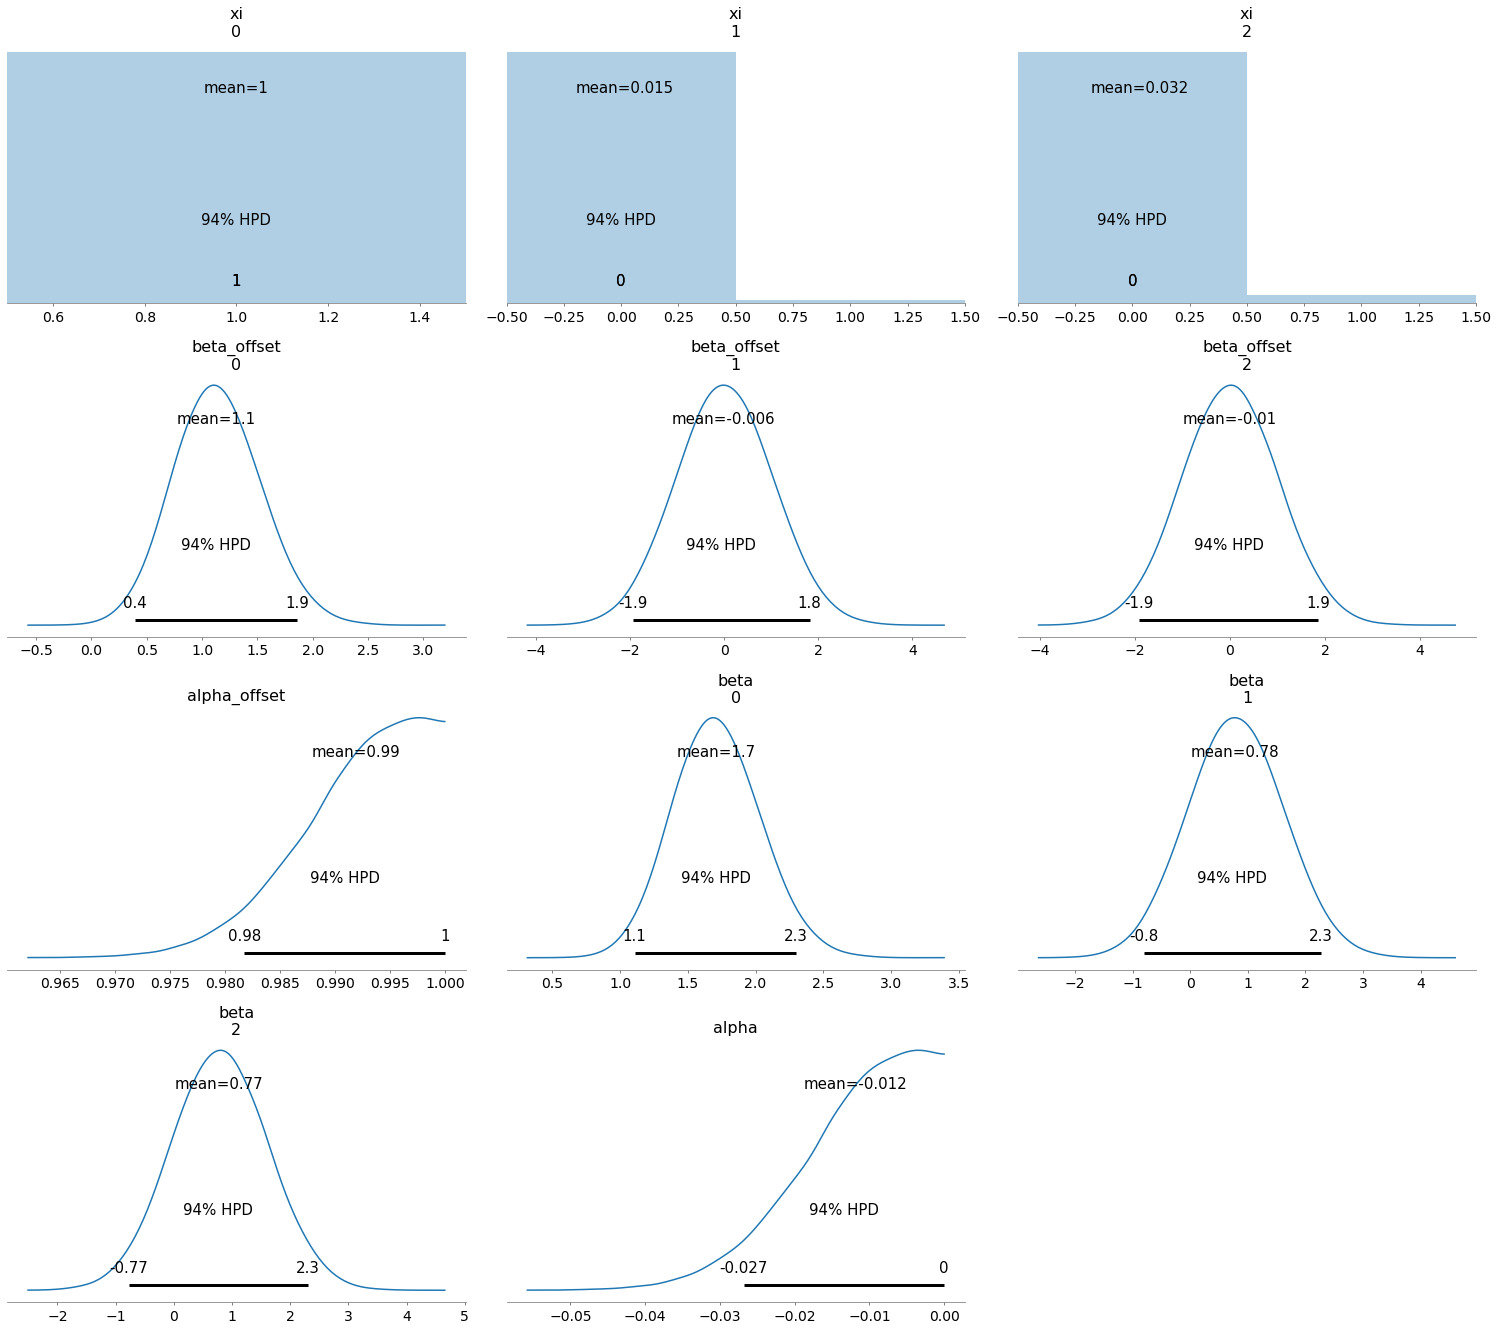

In [18]:
pm.plot_posterior(trace1)

In [45]:
def report_trace(trace):
    beta = trace['beta']
    mbeta = [np.mean(beta[:i]) for i in np.arange(1, len(beta))]
    plt.figure(figsize=(15, 4))
    plt.plot(mbeta, lw=2.5)
    plt.ylim(0.25, 1.5)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of beta')
    plt.title('MCMC estimation of beta')
    plt.show()
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

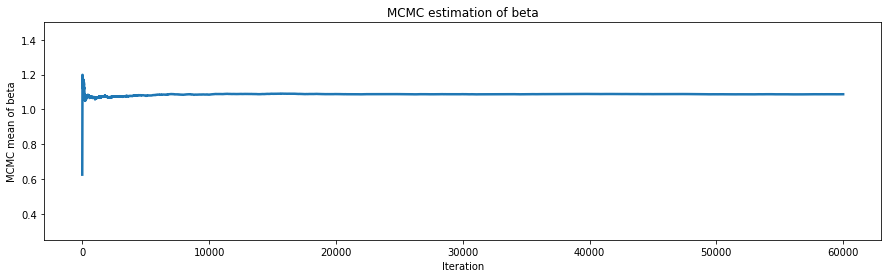

Number of Divergent 0
Percentage of Divergent 0.0


In [46]:
report_trace(trace1)

In [62]:
def pairplot_divergence(trace, ax=None, divergence=True, color='C3', divergence_color='C2', beta_para = 0):
    beta = trace.get_values(varname='beta', combine=True)[:, beta_para]
    alpha = trace.get_values(varname='alpha', combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(beta, alpha, 'o', color=color)
    if divergence:
        divergent = trace['diverging']
        ax.plot(beta[divergent], alpha[divergent], 'o', color=divergence_color)
    ax.set_xlabel('beta[0]')
    ax.set_ylabel('alpha')
    ax.set_title(f'scatter plot between alpha and beta{beta_para}')
    return ax

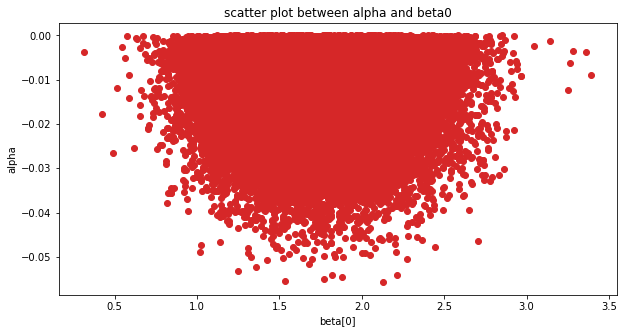

In [63]:
pairplot_divergence(trace1)